<a href="https://colab.research.google.com/github/weronikadomczewska/Uczenie-Glebokie-P/blob/main/first_step_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First step of the project
Training Resnet on CIFAR10 dataset (expected accuracy 90%)
https://medium.com/@thatchawin.ler/cifar10-with-resnet-in-pytorch-a86fe18049df

In [5]:
## Importing modules ##

# Import PyTorch
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms

# for file system
import os

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# for model evaluation
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import numpy as np

# for randimization
import random

# type
from typing import List , Dict , Tuple

In [6]:
# set device
device = torch.device('cuda')
print(device)

cuda


In [7]:
# Image augmentation transforms

# transforms object to use in data augmentation

mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

data_transform = transforms.Compose([
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Randomly rotate some images by 20 degrees
    transforms.RandomRotation(20),
    # Randomly adjust color jitter of the images
    transforms.ColorJitter(brightness = 0.1,contrast = 0.1,saturation = 0.1),
    # Randomly adjust sharpness
    transforms.RandomAdjustSharpness(sharpness_factor = 2,p = 0.2),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() ,
    #randomly erase a pixel
    transforms.Normalize(mean, std),
    transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)
])

In [8]:
# Load the training data once
dataset = torchvision.datasets.CIFAR10(
    root='/content/',
    train=True,
    download=True,
    transform=data_transform
)

# Split into train and validation
train_ratio = 0.8
val_ratio = 0.2
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

trainset, valset = random_split(dataset, [train_size, val_size])

# Load the original CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(
    root='/content/',
    train=False,
    download=True,
    transform=data_transform
)

# Classes are the same for train, val, and test
classes = dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 800

train_dataloader = DataLoader(dataset=trainset,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=testset,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

val_dataloader = DataLoader(dataset=valset,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=False)


# train loop function
def train_step(model:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               scheduler:torch.optim.lr_scheduler = None,
               grad_clip:float=None):

  model.train()

  train_loss = 0
  train_acc = 0

  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()

    if grad_clip:
      nn.utils.clip_grad_value_(model.parameters(), grad_clip)

    optimizer.step()
    y_pred_class = torch.argmax(y_pred,dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  if scheduler is not None:
    scheduler.step(train_loss)

  torch.save(model.state_dict(),'model_weights.pth')

  return train_loss , train_acc

# test loop function
def test_step(model:nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:nn.Module):

  model.eval()

  test_loss = 0
  test_acc = 0

  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()
      test_pred_labels = torch.argmax(test_pred_logits,dim=1)
      test_acc += (test_pred_labels == y).sum().item() / len(y)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss , test_acc

In [10]:
#Creating a train() function to combine train_step() and test_step()

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler:torch.optim.lr_scheduler,
          grad_clip:float=None,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           scheduler=scheduler,
                                           grad_clip=grad_clip)
        test_loss, test_acc = test_step(model=model,
            dataloader=val_dataloader,
            loss_fn=loss_fn)


        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )


        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [11]:
# function to plot loss & accuracy curve

def plot_loss_curves(results: Dict[str, List[float]]):

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()


    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

In [12]:
# function to plot loss & accuracy curve

def plot_loss_curves(results: Dict[str, List[float]]):
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()


    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.grid()
    plt.legend()

In [13]:
# create Resnet model class

class ResNet9(nn.Module):
    def conv_block(self, input_channels, output_channels, use_pool=False):
        layers = [nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                  nn.BatchNorm2d(output_channels),
                  nn.ReLU(inplace=True)]
        if use_pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)

    def __init__(self, input_channels, number_classes):
        super().__init__()

        self.conv1 = self.conv_block(input_channels, 64)
        self.conv2 = self.conv_block(64, 128, use_pool=True)
        self.residual1 = nn.Sequential(self.conv_block(128, 128), self.conv_block(128, 128))

        self.conv3 = self.conv_block(128, 256, use_pool=True)
        self.conv4 = self.conv_block(256, 512, use_pool=True)
        self.residual2 = nn.Sequential(self.conv_block(512, 512), self.conv_block(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Linear(512, number_classes))

    def forward(self, xb):
        layer1 = self.conv1(xb)
        layer2 = self.conv2(layer1)
        residual1 = self.residual1(layer2) + layer2
        layer3 = self.conv3(residual1)
        layer4 = self.conv4(layer3)
        residual2 = self.residual2(layer4) + layer4
        class_output = self.classifier(residual2)
        return class_output

In [14]:
# create model object
model_0 = ResNet9(3,10).to(device)


#[batch_size,color_channels,width,height]
summary(model_0, input_size=[1, 3, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet9                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-4                       [1, 128, 32, 32]          73,856
│    └─BatchNorm2d: 2-5                  [1, 128, 32, 32]          256
│    └─ReLU: 2-6                         [1, 128, 32, 32]          --
│    └─MaxPool2d: 2-7                    [1, 128, 16, 16]          --
├─Sequential: 1-3                        [1, 128, 16, 16]          --
│    └─Sequential: 2-8                   [1, 128, 16, 16]          --
│    │    └─Conv2d: 3-1                  [1, 128, 16, 16]          147,584
│

In [15]:
# Let's train
NUM_EPOCHS = 50
learning_rate = 0.01
weight_decay = 15e-5
grad_clip = 0.0001

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_0.parameters(),lr=learning_rate,weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min', factor=0.3,patience=3,threshold=0.09)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        grad_clip=grad_clip,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)


end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.8186 | train_acc: 0.2421 | test_loss: 1.9827 | test_acc: 0.2792
Epoch: 2 | train_loss: 1.6335 | train_acc: 0.4068 | test_loss: 2.2369 | test_acc: 0.2280
Epoch: 3 | train_loss: 1.3574 | train_acc: 0.5101 | test_loss: 2.1773 | test_acc: 0.2226
Epoch: 4 | train_loss: 1.2259 | train_acc: 0.5595 | test_loss: 2.0522 | test_acc: 0.2748
Epoch: 5 | train_loss: 1.1309 | train_acc: 0.6030 | test_loss: 1.9233 | test_acc: 0.3058
Epoch: 6 | train_loss: 1.0875 | train_acc: 0.6199 | test_loss: 1.7669 | test_acc: 0.4025
Epoch: 7 | train_loss: 1.0756 | train_acc: 0.6235 | test_loss: 2.1436 | test_acc: 0.2896
Epoch: 8 | train_loss: 1.0719 | train_acc: 0.6215 | test_loss: 1.7313 | test_acc: 0.3969
Epoch: 9 | train_loss: 1.0739 | train_acc: 0.6249 | test_loss: 1.3494 | test_acc: 0.5202
Epoch: 10 | train_loss: 1.0797 | train_acc: 0.6243 | test_loss: 3.3854 | test_acc: 0.1511
Epoch: 11 | train_loss: 0.8745 | train_acc: 0.6938 | test_loss: 1.3584 | test_acc: 0.5434
Epoch: 12 | train_l

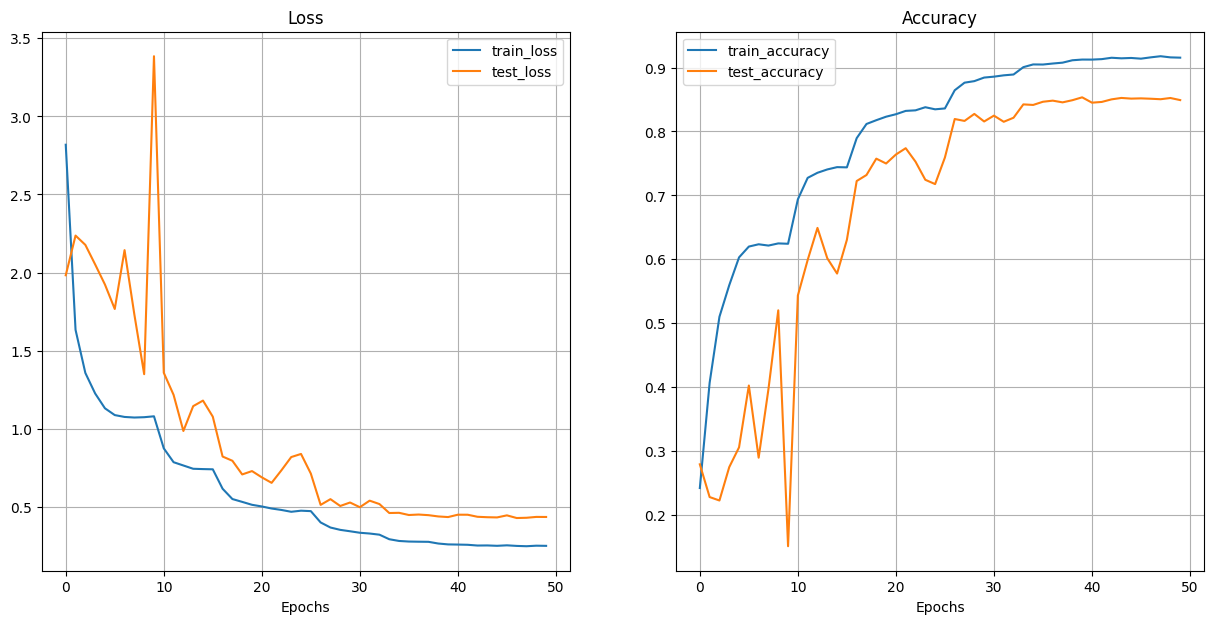

In [16]:
plot_loss_curves(model_0_results)

<Axes: >

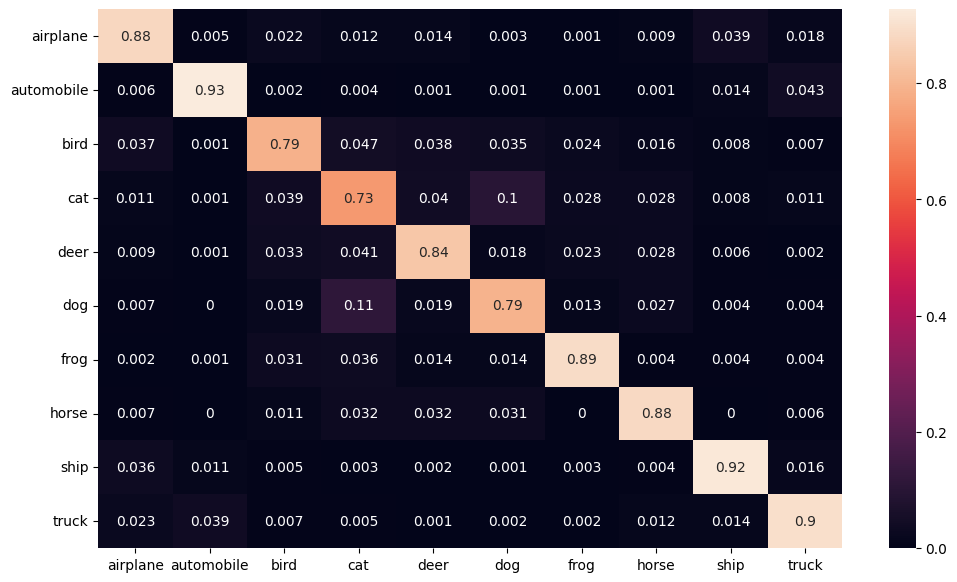

In [18]:
## Try predicting images with our model
predicted_labels = []
actual_labels = []

model_0.eval()

with torch.no_grad():  # We are using no_grad instead of inference_mode for better compatibility
  for images, labels in DataLoader(dataset=testset, batch_size=1, num_workers=NUM_WORKERS):
    images, labels = images.to(device), labels.to(device)
    prediction_logits = model_0(images)
    predictions = prediction_logits.argmax(dim=1).cpu().numpy()
    predicted_labels.extend(predictions)
    true_labels = labels.cpu().numpy()
    actual_labels.extend(true_labels)

confusion_mat = confusion_matrix(actual_labels, predicted_labels)
confusion_df = pd.DataFrame(confusion_mat/np.sum(confusion_mat)*10, index=classes, columns=classes)
plt.figure(figsize=(12,7))
sn.heatmap(confusion_df, annot=True)